In [24]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Load dataset
df = pd.read_csv('/kaggle/input/fraudulent-transactions-data/Fraud.csv')

print(f"Dataset: {df.shape}")
print(f"Fraud rate: {df['isFraud'].mean()*100:.2f}%")

# Preprocess
df['type'] = df['type'].map({"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5})
df = df.drop(['nameOrig', 'nameDest'], axis=1)

Dataset: (6362620, 11)
Fraud rate: 0.13%


Text(0, 0.5, 'Count')

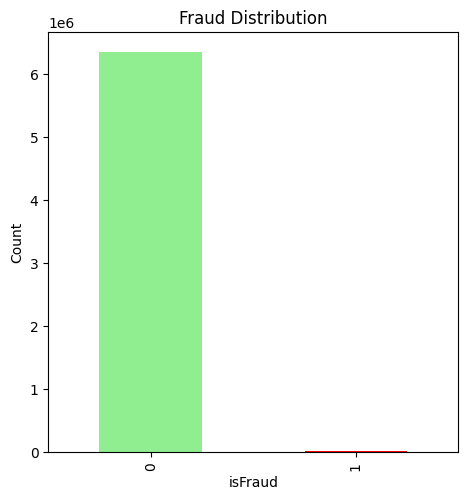

In [27]:
# Fraud distribution
plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 1)
df['isFraud'].value_counts().plot(kind='bar', color=['lightgreen', 'red'])
plt.title('Fraud Distribution')
plt.ylabel('Count')


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'CASH_OUT'),
  Text(1, 0, 'PAYMENT'),
  Text(2, 0, 'CASH_IN'),
  Text(3, 0, 'TRANSFER'),
  Text(4, 0, 'DEBIT')])

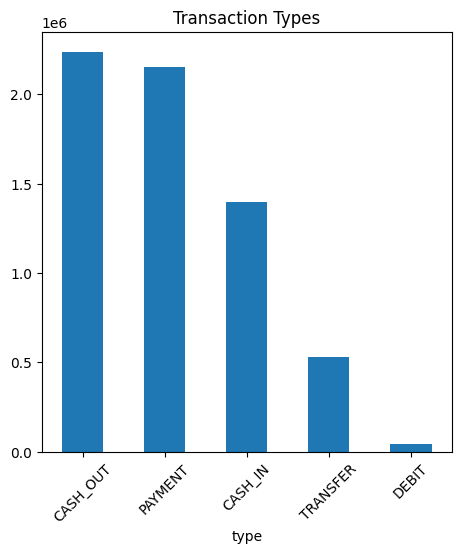

In [28]:
# Transaction types
plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 2)
type_names = {1: 'CASH_OUT', 2: 'PAYMENT', 3: 'CASH_IN', 4: 'TRANSFER', 5: 'DEBIT'}
df['type'].map(type_names).value_counts().plot(kind='bar')
plt.title('Transaction Types')
plt.xticks(rotation=45)

Text(0.5, 0, 'Amount')

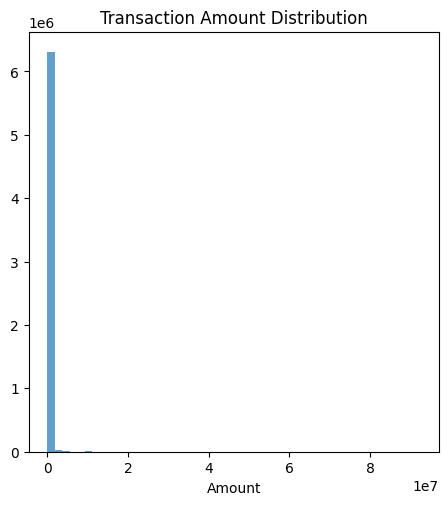

In [29]:
# Amount distribution
plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 3)
plt.hist(df['amount'], bins=50, alpha=0.7)
plt.title('Transaction Amount Distribution')
plt.xlabel('Amount')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'CASH_OUT'),
  Text(1, 0, 'PAYMENT'),
  Text(2, 0, 'CASH_IN'),
  Text(3, 0, 'TRANSFER'),
  Text(4, 0, 'DEBIT')])

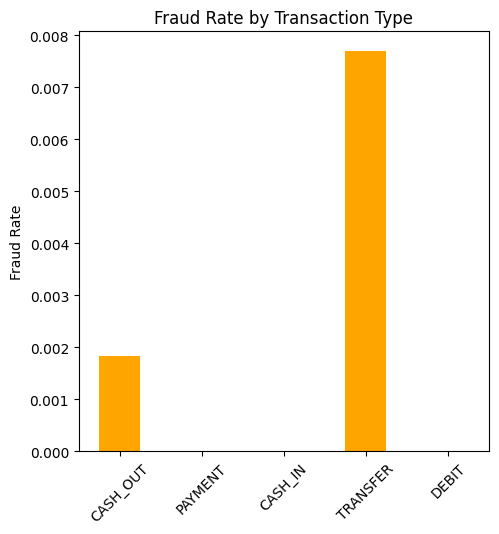

In [30]:
# Fraud by transaction type
plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 4)
fraud_by_type = df.groupby('type')['isFraud'].mean()
fraud_by_type.index = [type_names[i] for i in fraud_by_type.index]
fraud_by_type.plot(kind='bar', color='orange')
plt.title('Fraud Rate by Transaction Type')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)

Text(0, 0.5, 'Old Balance')

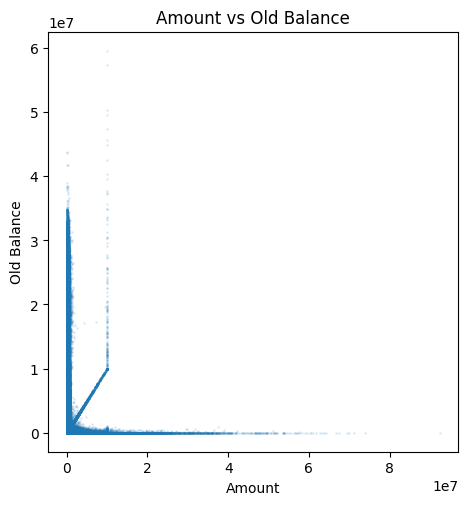

In [31]:
# Amount vs Balance
plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 5)
plt.scatter(df['amount'], df['oldbalanceOrg'], alpha=0.1, s=1)
plt.title('Amount vs Old Balance')
plt.xlabel('Amount')
plt.ylabel('Old Balance')

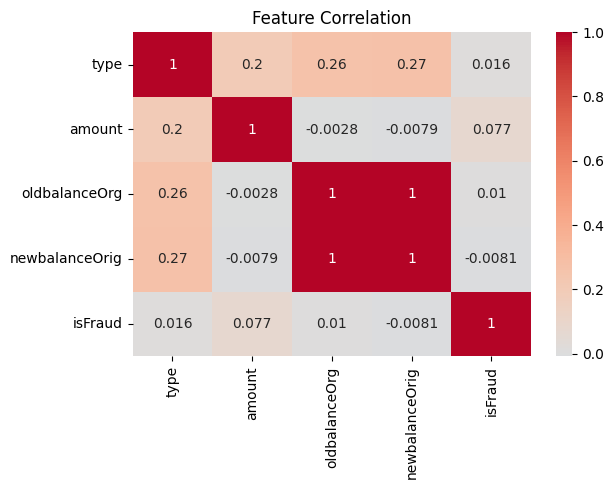

In [32]:
# Correlation matrix
plt.figure(figsize=(18, 12))
plt.subplot(3, 3, 9)
correlation_matrix = df[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'isFraud']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation')

plt.tight_layout()
plt.show()

Balanced dataset: 32,852 samples
Fraud ratio: 25.0%


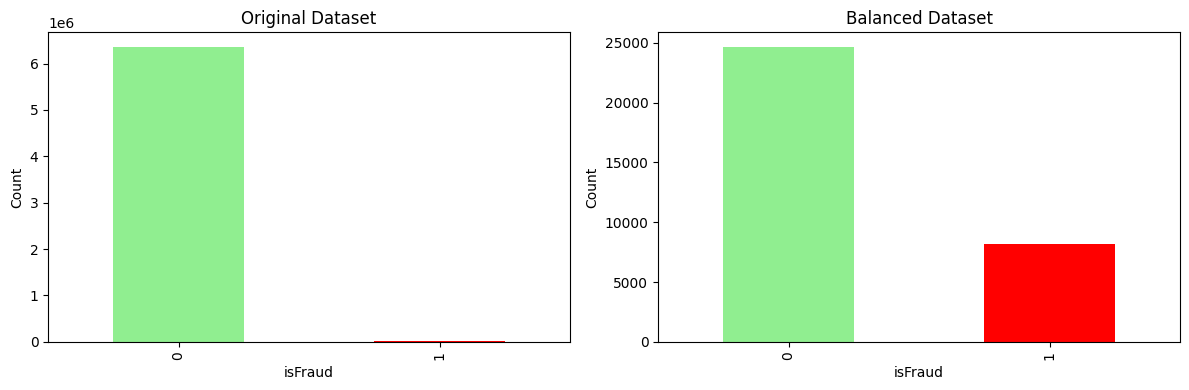

In [33]:
# Balance the dataset
fraud_cases = df[df['isFraud'] == 1]
no_fraud_cases = df[df['isFraud'] == 0]

# Undersample to 3:1 ratio
n_fraud_samples = len(fraud_cases)
no_fraud_undersampled = resample(
    no_fraud_cases,
    replace=False,
    n_samples=min(n_fraud_samples * 3, len(no_fraud_cases)),
    random_state=42
)

balanced_df = pd.concat([fraud_cases, no_fraud_undersampled])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced dataset: {len(balanced_df):,} samples")
print(f"Fraud ratio: {balanced_df['isFraud'].mean()*100:.1f}%")
# Visualize the improvement
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['isFraud'].value_counts().plot(kind='bar', color=['lightgreen', 'red'])
plt.title('Original Dataset')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
balanced_df['isFraud'].value_counts().plot(kind='bar', color=['lightgreen', 'red'])
plt.title('Balanced Dataset')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [34]:
# Features and target
X = balanced_df[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig']].values
y = balanced_df['isFraud'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling for some models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Model configurations
models = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [15, 20, 25, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': ['balanced']
        },
        'scaled': False
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [15, 20, 25],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': ['balanced']
        },
        'scaled': False
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [6, 8, 10],
            'subsample': [0.8, 0.9, 1.0]
        },
        'scaled': False
    },
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'C': [0.1, 1, 10, 100],
            'class_weight': ['balanced'],
            'solver': ['liblinear', 'lbfgs']
        },
        'scaled': True
    }
}

In [36]:
# Train and compare models
best_models = {}
results = []

for name, config in models.items():
    X_train_use = X_train_scaled if config['scaled'] else X_train
    X_test_use = X_test_scaled if config['scaled'] else X_test
    
    grid_search = GridSearchCV(
        config['model'], 
        config['params'], 
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    )
    
    grid_search.fit(X_train_use, y_train)
    best_model = grid_search.best_estimator_
    
    train_score = best_model.score(X_train_use, y_train)
    test_score = best_model.score(X_test_use, y_test)
    
    best_models[name] = {
        'model': best_model,
        'train_score': train_score,
        'test_score': test_score,
        'scaled': config['scaled']
    }
    
    results.append({
        'Model': name,
        'Train_Accuracy': train_score,
        'Test_Accuracy': test_score
    })

# Results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test_Accuracy', ascending=False)
print(results_df)

                Model  Train_Accuracy  Test_Accuracy
1        RandomForest        0.997565       0.995434
2    GradientBoosting        1.000000       0.994826
0        DecisionTree        0.999810       0.994217
3  LogisticRegression        0.934592       0.929082


In [37]:
# Get best model
best_model_name = results_df.iloc[0]['Model']
final_model = best_models[best_model_name]['model']
use_scaled = best_models[best_model_name]['scaled']

X_test_final = X_test_scaled if use_scaled else X_test
y_pred = final_model.predict(X_test_final)

print(f"\nBest model: {best_model_name}")
print(f"Test accuracy: {final_model.score(X_test_final, y_test):.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud']))


Best model: RandomForest
Test accuracy: 0.9954

Classification Report:
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00      4928
       Fraud       0.99      0.99      0.99      1643

    accuracy                           1.00      6571
   macro avg       0.99      1.00      0.99      6571
weighted avg       1.00      1.00      1.00      6571



In [38]:
# Test with sample cases
test_cases = [
    [1, 50000.0, 100000.0, 50000.0],  # Large cash out
    [2, 1000.0, 5000.0, 4000.0],      # Normal payment
    [1, 45000.0, 45000.0, 0.0],       # Account drain
    [3, 2000.0, 1000.0, 3000.0],      # Cash deposit
]

transaction_types = {1: "CASH_OUT", 2: "PAYMENT", 3: "CASH_IN", 4: "TRANSFER", 5: "DEBIT"}

for i, case in enumerate(test_cases):
    case_input = scaler.transform([case]) if use_scaled else [case]
    pred = final_model.predict(case_input)[0]
    prob = final_model.predict_proba(case_input)[0]
    
    result = "FRAUD" if pred == 1 else "NO FRAUD"
    type_name = transaction_types[case[0]]
    
    print(f"{type_name} ${case[1]:,.2f} -> {result} ({prob[1]:.3f})")

CASH_OUT $50,000.00 -> NO FRAUD (0.000)
PAYMENT $1,000.00 -> NO FRAUD (0.000)
CASH_OUT $45,000.00 -> FRAUD (0.974)
CASH_IN $2,000.00 -> NO FRAUD (0.000)


In [39]:
cm = confusion_matrix(y_test, y_pred)
print(f"True Negatives: {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")  
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives: {cm[1,1]:,}")

from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

True Negatives: 4,907
False Positives: 21
False Negatives: 9
True Positives: 1,634
Precision: 0.9873
Recall: 0.9945
F1-Score: 0.9909



🎯 Feature Importance Analysis:
         Feature  Importance
     Old Balance    0.410697
     New Balance    0.228228
          Amount    0.227833
Transaction Type    0.133242


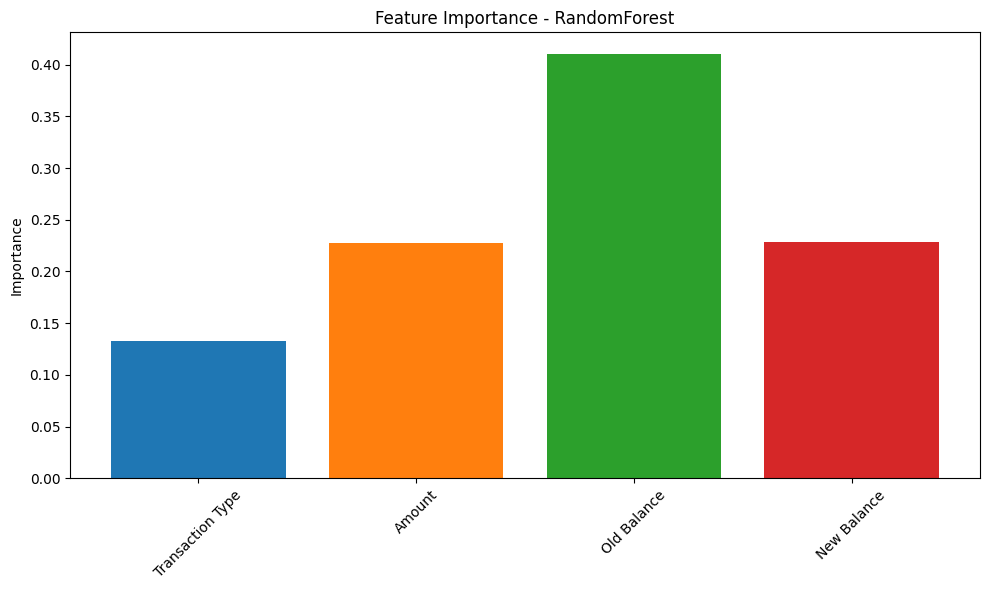

In [40]:
# Analyze feature importance
if hasattr(final_model, 'feature_importances_'):
    feature_names = ['Transaction Type', 'Amount', 'Old Balance', 'New Balance']
    importance = final_model.feature_importances_
    
    print(f"\n🎯 Feature Importance Analysis:")
    feature_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    print(feature_imp_df.to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, importance, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.title(f'Feature Importance - {best_model_name}')
    plt.ylabel('Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

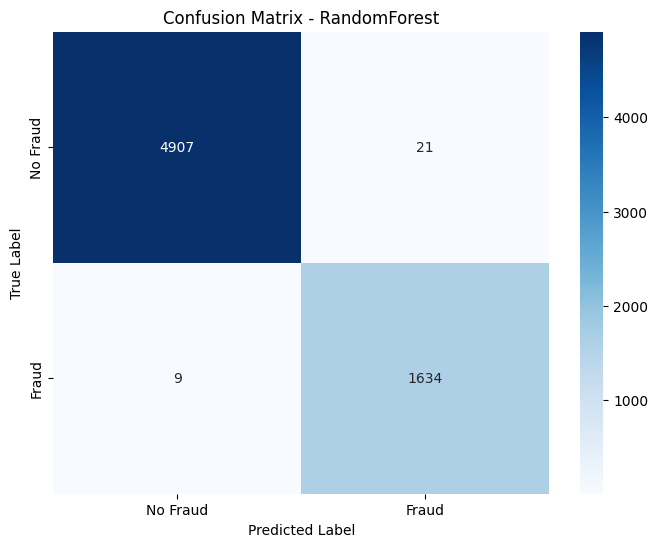

In [41]:
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraud', 'Fraud'],
            yticklabels=['No Fraud', 'Fraud'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [42]:
# Test with sample cases
test_cases = [
    [1, 50000.0, 100000.0, 50000.0],  # Large cash out
    [2, 1000.0, 5000.0, 4000.0],      # Normal payment
    [1, 45000.0, 45000.0, 0.0],       # Account drain
    [3, 2000.0, 1000.0, 3000.0],      # Cash deposit
]

transaction_types = {1: "CASH_OUT", 2: "PAYMENT", 3: "CASH_IN", 4: "TRANSFER", 5: "DEBIT"}

for i, case in enumerate(test_cases):
    case_input = scaler.transform([case]) if use_scaled else [case]
    pred = final_model.predict(case_input)[0]
    prob = final_model.predict_proba(case_input)[0]
    
    result = "FRAUD" if pred == 1 else "NO FRAUD"
    type_name = transaction_types[case[0]]
    
    print(f"{type_name} ${case[1]:,.2f} -> {result} ({prob[1]:.3f})")

CASH_OUT $50,000.00 -> NO FRAUD (0.000)
PAYMENT $1,000.00 -> NO FRAUD (0.000)
CASH_OUT $45,000.00 -> FRAUD (0.974)
CASH_IN $2,000.00 -> NO FRAUD (0.000)
